Countermeasures
---------------------

This notebook contains two sets of analyses:

* [Country-level aggregates](#National-countermeasures): causal impact of individual countermeasures on new confirmed cases in national aggregate data.
* [Analysis across countries](#Package-effectiveness): comparative analysis of the effectiveness of packages of countermeasures across nations.

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
pd.options.display.max_colwidth = 200

#### John Hopkins containment measures database

The data is made available as part of the John Hopkins [Containment Measures Database](http://epidemicforecasting.org/containment). See the website in the link for a description of the data sources.

In [3]:
containment_df = pd.read_csv("data/countermeasures_db_johnshopkins_2020_03_30.csv")

### Exploratory analysis

In [4]:
containment_df.columns

Index(['Unnamed: 0', 'Symptomatic isolation - targeted',
       'Symptomatic isolation - blanket', 'Asymptomatic isolation - targeted',
       'Asymptomatic isolation - blanket', 'Domestic travel restriction',
       'International travel restriction', 'Testing', 'Contact tracing',
       'Mask wearing', 'Hand washing', 'Gatherings banned',
       'Healthcare specialisation', 'Public education and incentives',
       'Assisting people to stay home', 'Public cleaning',
       'Miscellaneous hygiene measures', 'Public interaction reduction',
       'Nonessential business suspension', 'School closure',
       'Activity cancellation', 'Resumption', 'Diagnostic criteria loosened',
       'Diagnostic criteria tightened', 'Testing criteria', 'Date', 'Country',
       'Confirmed Cases', 'Deaths'],
      dtype='object')

In [5]:
print(containment_df["Country"].unique())

['Austria' 'Germany' 'United Kingdom' 'Vietnam' 'South Korea' 'Singapore'
 'Israel' 'Japan' 'Sweden' 'San Marino' 'Slovenia' 'Canada' 'Taiwan'
 'Macau' 'Hong Kong' 'China' 'Thailand' 'Italy' 'Czechia' 'Australia'
 'Trinidad and Tobago' 'Qatar' 'New Zealand' 'Colombia' 'Romania' 'France'
 'Portugal' 'Spain' 'Belgium' 'Luxembourg' 'Albania' 'Andorra'
 'Azerbaijan' 'Belarus' 'Bosnia and Herzegovina' 'Bulgaria' 'Denmark'
 'Estonia' 'Cyprus' 'Croatia' 'Finland' 'Georgia' 'Hungary' 'Latvia'
 'Lithuania' 'Greece' 'Moldova' 'Malta' 'Monaco' 'Netherlands' 'Iceland'
 'Ireland' 'Kosovo' 'Kazakhstan' 'Poland' 'Turkey' 'Ukraine' 'Slovakia'
 'Serbia' 'Switzerland' 'Norway' 'Montenegro' 'Iran' 'Liechtenstein'
 'Russia' 'Mexico' 'Egypt' 'Malaysia' 'Nepal' 'Afghanistan' 'Iraq'
 'Philippines' 'Kuwait' 'South Africa' 'Armenia' 'Pakistan' 'Brazil'
 'Costa Rica' 'Panama' 'India' 'Bahrain' 'United Arab Emirates'
 'Kyrgyzstan' 'Indonesia' 'Namibia' 'Uganda']


In [6]:
other_cm_cols = ['Unnamed: 0', 'Resumption', 'Diagnostic criteria loosened', 'Testing criteria', 'Date', 'Country',
                 'Confirmed Cases', 'Deaths']

In [7]:
countermeasures = list(filter(lambda m: m not in other_cm_cols, containment_df.columns))

In [8]:
cm_df = containment_df[countermeasures + ['Date', 'Country']].fillna(0)

In [9]:
cm_df[countermeasures] = cm_df[countermeasures].mask(cm_df[countermeasures] > 0, 1)

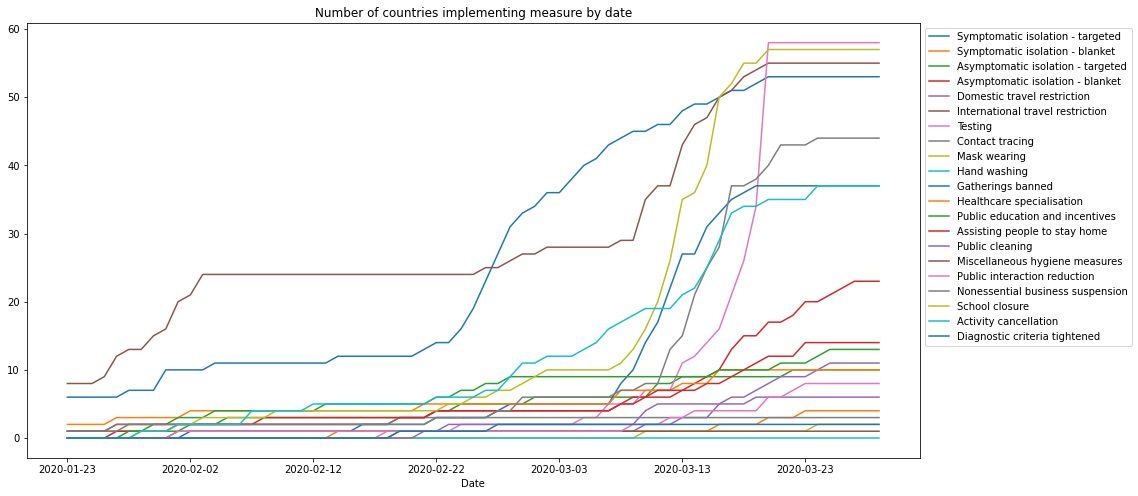

In [10]:
cm_df.groupby("Date").sum().plot(figsize=(16,8), title="Number of countries implementing measure by date")\
.legend(bbox_to_anchor=(1,1))

#### Countermeasure dataset

In [11]:
df = containment_df[countermeasures + ["Date", "Country", "Confirmed Cases", "Deaths"]].fillna(0)

In [12]:
df.head()

,Symptomatic isolation - targeted,Symptomatic isolation - blanket,Asymptomatic isolation - targeted,Asymptomatic isolation - blanket,Domestic travel restriction,International travel restriction,Testing,Contact tracing,Mask wearing,Hand washing,...,Miscellaneous hygiene measures,Public interaction reduction,Nonessential business suspension,School closure,Activity cancellation,Diagnostic criteria tightened,Date,Country,Confirmed Cases,Deaths
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-23,Austria,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-23,Germany,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-23,United Kingdom,0,0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-23,Vietnam,2,0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-23,South Korea,1,0


In [13]:
df[countermeasures] = df[countermeasures].mask(df[countermeasures] > 0, 1.0)

## National countermeasures

Exploration of the impact of individual and packages of countermeasures on the incidence of reported new confirmed cases of COVID-19 in a single country.

In [14]:
country = "Germany"
treatment = "Nonessential business suspension"

In [15]:
country_df = df[df["Country"] == country].sort_values(by="Date")

In [16]:
country_df[["New Confirmed Cases", "Reported Deaths"]] = country_df[["Confirmed Cases", "Deaths"]].diff()

In [17]:
country_df = country_df.fillna(0)

In [18]:
country_df.loc[country_df[treatment].idxmax(1.0):, ["Date", "New Confirmed Cases", "Reported Deaths"]]

,Date,New Confirmed Cases,Reported Deaths
4387,2020-03-14,910.0,2.0
4473,2020-03-15,1210.0,2.0
4559,2020-03-16,1477.0,6.0
4645,2020-03-17,1985.0,7.0
4731,2020-03-18,3070.0,4.0
4817,2020-03-19,2993.0,16.0
4903,2020-03-20,4528.0,23.0
4989,2020-03-21,2365.0,17.0
5075,2020-03-22,2660.0,10.0
5161,2020-03-23,4183.0,29.0


In [19]:
country_df.head()

,Symptomatic isolation - targeted,Symptomatic isolation - blanket,Asymptomatic isolation - targeted,Asymptomatic isolation - blanket,Domestic travel restriction,International travel restriction,Testing,Contact tracing,Mask wearing,Hand washing,...,Nonessential business suspension,School closure,Activity cancellation,Diagnostic criteria tightened,Date,Country,Confirmed Cases,Deaths,New Confirmed Cases,Reported Deaths
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2020-01-23,Germany,0,0,0.0,0.0
87,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2020-01-24,Germany,0,0,0.0,0.0
173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2020-01-25,Germany,0,0,0.0,0.0
259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2020-01-26,Germany,0,0,0.0,0.0
345,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2020-01-27,Germany,1,0,1.0,0.0


## Causal impact of individual countermeasures

[Causal impact](https://github.com/tcassou/causal_impact) provides causal inference using Bayesian structural time-series models. It was used here to analyse the effect of different COVID-19 countermeasures (`treatment`) on the number of new confirmed cases per day. Since most countermeasures were implemented as a package (e.g. *Nonessential business suspension* will often be done one or two days before or after *School closure*), the treatment start date should be interpreted as a proxy of a package of measures. A next step will be to do cross-country comparisons of different packages (combinations of measures) to see which package had the most positive impact relative to country population size and mortality rate.

In [20]:
ci_df = country_df[["Date", "Reported Deaths", "New Confirmed Cases"]].set_index("Date")

In [21]:
ci_df = ci_df.rename(columns={"New Confirmed Cases": "y"})

In [22]:
measure_start_date = country_df.loc[country_df[treatment].idxmax(1.0):, ['Date']].values[0][0]

In [23]:
print(f"Date that the '{treatment}' treatment was first implemented in {country}: {measure_start_date}.")

Date that the 'Nonessential business suspension' treatment was first implemented in Germany: 2020-03-14.


In [24]:
measure_keys = country_df.loc[country_df[treatment].idxmax(1.0):, countermeasures].keys()
measures_on_start_date = list(country_df.loc[country_df[treatment].idxmax(1.0):, countermeasures].values[0])
active_measures = list(filter(lambda m: m[1] == 1.0 and m[0] != treatment, 
                              list(zip(measure_keys, measures_on_start_date))))

In [25]:
print(f"Other measures active in {country} on {measure_start_date}:\n\n{', '.join(list(map(lambda am: am[0], active_measures)))}.")

Other measures active in Germany on 2020-03-14:

International travel restriction, Gatherings banned, Public education and incentives, Public interaction reduction, School closure, Activity cancellation.


In [26]:
from causal_impact.causal_impact import CausalImpact

ci = CausalImpact(ci_df, country_df.loc[country_df[treatment].idxmax(1.0):, ["Date"]].values[0][0])

In [27]:
ci.run()

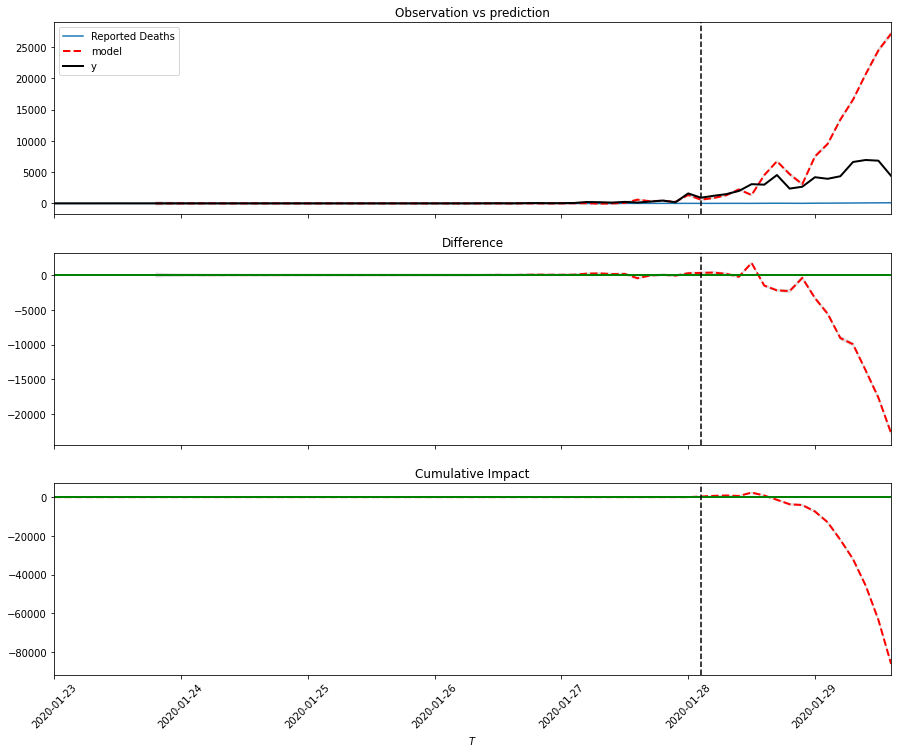

In [28]:
ci.plot()

Package effectiveness
---------------------------